# 'Auto-Tag' Images using a Controlled Vocabulary

This is a follow-up to the `media_topics_structured_output.ipynb` and `media_topic_RAG.ipynb` notebooks that demonstrate AI 'auto-tagging' using the IPTC Media Topics controlled vocabulary and the Google Gemini API. In the previous two notebooks we classified text. Here we will classify an image.

## Import Python Packages

In [74]:
from pydantic import BaseModel, Field
from PIL import Image
from google import genai
import chromadb
import pandas as pd
import json
import os
import requests
from IPython.display import display
import pprint
from collections import Counter
from dotenv import load_dotenv


load_dotenv()

GOOGLE_AI_API_KEY = os.getenv("GOOGLE_AI_API_KEY")

# Initialize the GenAI client
client = genai.Client(api_key=GOOGLE_AI_API_KEY)

In [75]:
pd.set_option("display.max_rows", 100)

## IPTC Media Topics Controlled Vocabulary

Media Topics is a constantly updated taxonomy of over 1,200 terms with a focus on categorising text.

Originally based on the IPTC Subject Codes taxonomy, the Media Topics taxonomy was first released  in 2010 and is updated at least once a year.

https://iptc.org/standards/media-topics/


### Download and Read JSON


In [43]:
MEDIATOPICS_URL = "https://cv.iptc.org/newscodes/mediatopic?lang=en-US&format=json"

MEDIATOPICS_PATH = "./schema/mediatopic_cptall-en-US.json"

# Function to download the Media Topics JSON file
def download_mediatopics_json():
    try:
        # request media topics
        response = requests.get(MEDIATOPICS_URL)
        # check if the request was successful
        response.raise_for_status()
        # parse the JSON content into a dictionary
        data = response.json()
        # create the schema directory if it doesn't exist
        os.makedirs("./schema", exist_ok=True)
        # write the data to the JSON file
        with open(MEDIATOPICS_PATH, 'w') as f:
            json.dump(data, f, indent=4)

    except requests.exceptions.RequestException as e:
        print(f"Error during request: {e}")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
    except IOError as e:
        print(f"Error writing to file: {e}")

# Download the Media Topics JSON file if it doesn't exist
if not os.path.exists(MEDIATOPICS_PATH):
    print("Downloading Media Topics Controlled Vocabulary from IPTC web")
    download_mediatopics_json()
# Load the Media Topics JSON file
with open(MEDIATOPICS_PATH, "r") as file:
    media_topics = json.load(file)

In [44]:
# Let's load the concepts into a dictionary for easier access later
concepts_dict = {concept['qcode']: concept for concept in media_topics['conceptSet']}

In [45]:
# Let's look at the top concepts and their definitions
top_concept_dict = {}  # dictionary to hold top concepts and their definitions
for concept_uri in media_topics.get("hasTopConcept", []):
    # extract the concept qcode from the URI
    qcode = f"medtop:{concept_uri.split('/')[-1]}"
    concept = concepts_dict.get(qcode)
    # add the broad concept to the dictionary
    concept_label= concept.get('prefLabel', {}).get('en-US', 'None')
    top_concept_dict[concept_label] = concept.get('definition', {}).get('en-US', 'None')

### Build Vector DB

In [46]:
# Prepare Ids and Documents
# Let's load the ids and documents that we will be storing in the vector db.
# Our ids are Media Topic's `qcode` and the documents concept definitions.

ids = []
documents = []
for key, val in concepts_dict.items():
    ids.append(key)
    documents.append(val.get('definition').get('en-US'))

print(ids[:5])
print(documents[:5])

# What's the average number of words in a media topic definition?
average_number_of_words = sum([len(definition.split(" ")) for definition in documents]) / len(documents)
print(average_number_of_words)

# Create a Database Client
chroma = chromadb.Client()
# Create a Database Collection
collection = chroma.get_or_create_collection(name="media_topics")
# Add Media Topics Vocabulary to Database
collection.upsert(
    ids=ids,
    documents=documents
)

['medtop:01000000', 'medtop:02000000', 'medtop:03000000', 'medtop:04000000', 'medtop:05000000']
['All forms of arts, entertainment, cultural heritage and media', 'The establishment and/or statement of the rules of behavior in society, the enforcement of these rules, breaches of the rules, the punishment of offenders and the organizations and bodies involved in these activities', 'Man made or natural event resulting in loss of life or injury to living creatures and/or damage to inanimate objects or property', 'All matters concerning the planning, production and exchange of wealth.', 'All aspects of furthering knowledge, formally or informally']
15.38433908045977


## Image Captioning

Let's write a caption for our image using Google Gemini. Our `CaptionResponse` class makes sure our response is just the caption we asked for, nothing more.

In [34]:
class CaptionResponse(BaseModel):
    caption: str = Field(..., description="A long, descriptive, and thorough caption for the image using "
                                          "concepts from the IPTC Media Topics controlled vocabulary.")
    concepts: list[str] = Field(..., description="Broad level concepts relevant to the image contents.")


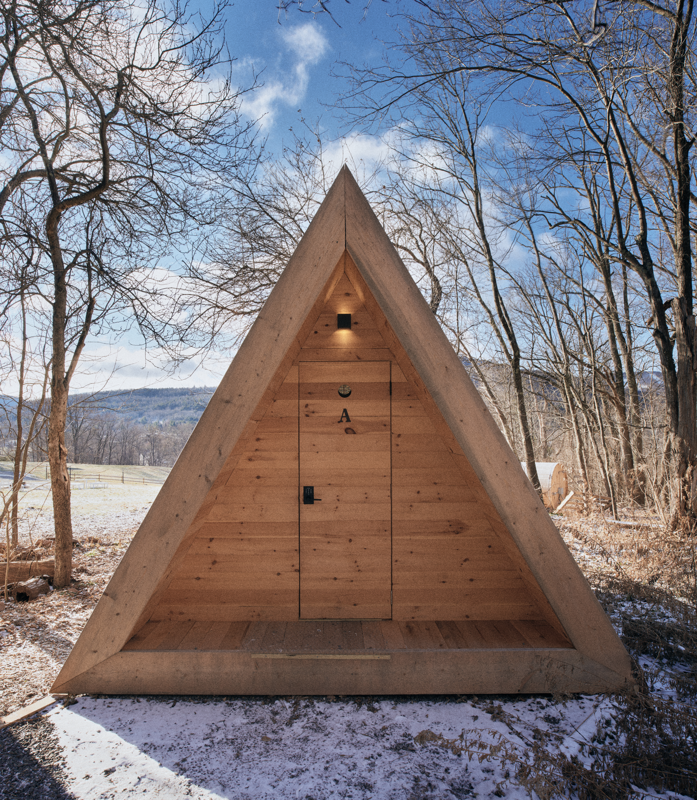

In [83]:
# Open the image, resize, and display
img = Image.open("../images/20181225_P8J1057_LM.jpg") # Open the image
w, h = img.size
resize_factor = h / 800
img = img.resize(size=(int(w // resize_factor), int(h // resize_factor)))
display(img)

### Gemini System Instructions

How should our LLM behave? Let's write some instructions for it to follow along with some information regarding the Media Topics controlled vocabulary.

In [36]:
system_instructions = f"""# Role
* You are an expert digital asset librarian specializing in the IPTC Media Topics Controlled Vocabulary.
# Rules
* Given an image, you generate a detailed description of everything that you see.
* You should adhere to the concepts as defined in the vocabulary.
# Broad Level Vocabulary Conecpts
{json.dumps(top_concept_dict)} 
"""

### Generate an Exhaustive Image Description

In [ ]:
def generate_image_caption(image: Image):
    response = client.models.generate_content(
        model='gemini-2.5-flash',
        contents=["Write an exhaustive caption for this image", image],
        config=genai.types.GenerateContentConfig(
            system_instruction=system_instructions,
            response_mime_type="application/json",
            response_json_schema=CaptionResponse.model_json_schema(),
        )
    )

    caption_response = CaptionResponse.model_validate_json(response.text)

    return caption_response

In [38]:
caption = generate_image_caption(image=img)

In [39]:
pprint.pprint(caption.caption)

('A striking wooden A-frame cabin, characterized by its distinctive triangular '
 'architecture, stands amidst a serene winter environment. The structure, '
 'constructed from light-toned wooden planks, features a central dark door '
 "with a minimalist handle and the letter 'A' painted above it. An integrated "
 'light fixture above the entrance provides illumination. The ground around '
 'the cabin is covered with a light dusting of snow, mixed with patches of dry '
 'vegetation and gravel, reflecting the cold weather conditions. Bare '
 'deciduous trees with intricate branch patterns frame the scene under a clear '
 'blue sky with sparse white clouds. In the background, a vast natural '
 'landscape unfolds, revealing rolling hills, a snow-covered field with '
 'fencing, and another small, barrel-shaped structure nestled amongst the '
 'trees. This scene captures an aspect of unique living or leisure, '
 'emphasizing a connection to nature and a lifestyle focused on the '
 'environme

### Broad vocabular concepts

We gave our caption generation model the 17 broad Media Topics concepts and asked it to return a list of relevent concepts. It's interesting that here the model doesn't always return the concept labels word-for-word. We can retrieve the most relevant term in the vocabulary by searching the vector db.

In [40]:
pprint.pprint(caption.concepts)

['lifestyle and leisure', 'environment', 'weather']


In [51]:
results = collection.query(
    query_texts=caption.concepts, 
    n_results=1
    )

In [56]:
tags = []
for qcode in results.get('ids', [[]]):
    concept = concepts_dict.get(qcode[0])
    tags.append(concept.get('prefLabel', {}).get('en-US'))

print(tags)

['outdoor recreational activities', 'nature', 'weather forecast']


## Retrieve Tag Candidates

Let's retrieve the relevant tags from the vocabulary based on the generated image captions.

### Chunking

Let's take our text and split it into chunks. Each chunk will get queried. The results will have the top n tags for each chunk.

In [61]:
# Define a simple chunking strategy with a sliding window
def chunking_strategy(text_to_chunk: str, chunk_size: int) -> list[str]:
    word_list = []

    for line in text_to_chunk.split("\n"):
        for word in line.split(" "):
            word_list.append(word.strip())

    res = []

    # sliding window
    low, hi = 0, chunk_size
    while hi < len(word_list):
        res.append(" ".join(word_list[low:hi]))
        low += 5
        hi += 5

    return res

# Chunk the caption
chunks = chunking_strategy(
    text_to_chunk=caption.caption,
    chunk_size=int(average_number_of_words)
    )

display(chunks[:10])

['A striking wooden A-frame cabin, characterized by its distinctive triangular architecture, stands amidst a serene',
 'characterized by its distinctive triangular architecture, stands amidst a serene winter environment. The structure, constructed',
 'architecture, stands amidst a serene winter environment. The structure, constructed from light-toned wooden planks, features',
 'winter environment. The structure, constructed from light-toned wooden planks, features a central dark door with',
 'from light-toned wooden planks, features a central dark door with a minimalist handle and the',
 "a central dark door with a minimalist handle and the letter 'A' painted above it.",
 "a minimalist handle and the letter 'A' painted above it. An integrated light fixture above",
 "letter 'A' painted above it. An integrated light fixture above the entrance provides illumination. The",
 'An integrated light fixture above the entrance provides illumination. The ground around the cabin is',
 'the entranc

### Query the Database with Chunks

In [63]:
results = collection.query(query_texts=chunks, n_results=10)

In [65]:
# Iterate through the results and count the tag occurences
tags = Counter()
for r in results.get('ids', []):
    for qcode in r:
        tags[qcode] += 1
        
# Lookup the labels from the tags and display their counts
labels_and_counts = []
for qcode, count in tags.most_common(n=10):
    concept = concepts_dict.get(qcode)
    label = concept.get('prefLabel', {}).get('en-US')
    labels_and_counts.append((label, count))

display(pd.DataFrame(labels_and_counts, columns=["Tag", "Count"]))

,Tag,Count
0,architecture,11
1,windstorms,10
2,avalanche,10
3,ice climbing,8
4,forest,8
5,outdoor recreational activities,8
6,church,6
7,house and home,6
8,flood,6
9,wetland,6


## Gemini Classifier

Let's use Google Gemini to classify our image using the retrieved concepts from our controlled vocabulary.

In [69]:
# Define the response schema for classification
def load_json_response_schema(concepts: list[str]) -> dict:
    """Load a JSON schema for the given concepts."""

    response_schema = {
        '$defs': {
            'Tags': {
                'enum': concepts, 
                'title': 'Tags', 
                'type': 'string'
                }
            }, 
        'properties': {
            'keywords': {
                'items': {
                    '$ref': '#/$defs/Tags'
                    }, 
                'title': 'Keywords', 
                'type': 'array'
                }
            }, 
        'required': ['keywords'], 
        'title': 'Metadata', 
        'type': 'object'
        }
    
    return response_schema

# Create Controlled Vocab Response Schema
# All of the relevant tags from the database query become our LLM's controlled vocabulary.
response_enum_vals = []
for qcode, count in tags.most_common(n=75):
    concept = concepts_dict.get(qcode)
    label = concept.get('prefLabel', {}).get('en-US')
    response_enum_vals.append(label)


# Create the response schema
response_schema = load_json_response_schema(response_enum_vals)

### Classify the image!

Send our image to the model for classification using the most relevant Media Topics concepts.

In [70]:
# Function to classify media topics using GenAI
def classify_media_topics(image: Image, response_schema: dict) -> genai.types.GenerateContentResponse:
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[image],
        config=genai.types.GenerateContentConfig(
            system_instruction="Extract relevant media topics from the text based on the IPTC Media Topics Controlled Vocabulary. Respond with a JSON object containing an array of 'keywords' that correspond to the 'qcode' values from the Media Topics vocabulary. Only include keywords that are directly relevant to the content provided. Do not include any additional text or explanation outside of the JSON object.",
            temperature=1.0,
            response_mime_type="application/json",
            response_schema=response_schema
        )
    )
    return response

In [71]:
response_object = classify_media_topics(image=img, response_schema=response_schema)

### Classification Results

Let's see how our classifier classified our text. The response object can be parsed directly by the sdk to see the resulting list of keywords.

In [72]:
classification_results = response_object.parsed
display(classification_results)

{'keywords': ['architecture',
  'forest',
  'house and home',
  'weather',
  'nature',
  'lifestyle and leisure',
  'travel and tourism',
  'residential real estate',
  'house building',
  'hotel and accommodation',
  'building material',
  'outdoor recreational activities']}

In [73]:
print(f"Our text was classified into {len(classification_results['keywords'])} media topics.")

Our text was classified into 12 media topics.
